edwith의 부스트 코스 : "파이토치로 시작하는 딥러닝 기초" 를 바탕으로 작성되었습니다.  
https://www.boostcourse.org/ai214

# Dropout

- Overfitting
- Dropout
- Full code : mnist_nn_drop

## Overfitting
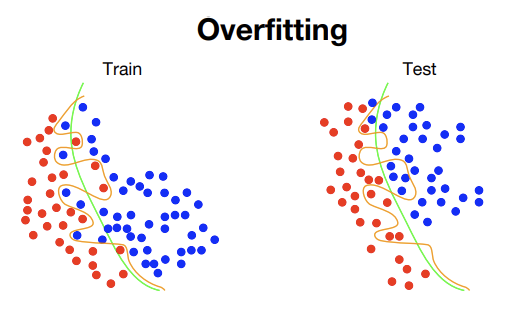

Solutions for overfitting
* More training data
* Reduce the number of features 
* Regularization 
* **Dropout**

## Dropout
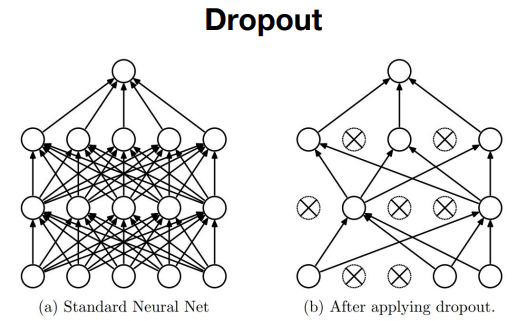

학습을 진행하면서 각 layer에 존재하는 노드, 뉴런들을 설정된 비율에 따라 무작위로 비활성하는 방법  
활성화된 특정 노드들만 weight를 다음 layer에 넘겨줌으로써 학습이 진행됨. 이를 통해 overfitting 을 방지하고 성능향상을 이끌어낼 수 도 있음. 관점에 따라서는 매번 다른형태의 network 구조들이 다른 결과를 내고 학습하는 형태이기 때문에 여러 형태의 network들의 최종결과를 합친 앙상블의 효과를 얻을 수도 있다라는 의견도 존재함. 

## Full code : mnist_nn_drop

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
torch.manual_seed(777)
if device == 'cuda': 
    torch.cuda.manual_seed_all(777)

In [3]:
learning_rate = 0.001
traing_epochs = 15
batch_size = 100
drop_prob = 0.5

In [4]:
mnist_train = dsets.MNIST(root='../MNIST_data/',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=False)

mnist_test = dsets.MNIST(root='../MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=False)

In [5]:
data_loader = torch.utils.data.DataLoader(mnist_train,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)

In [6]:
# nn layer
linear1 = torch.nn.Linear(784, 512, bias=True)
linear2 = torch.nn.Linear(512, 512, bias=True)
linear3 = torch.nn.Linear(512, 512, bias=True)
linear4 = torch.nn.Linear(512, 512, bias=True)
linear5 = torch.nn.Linear(512, 10, bias=True)
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=drop_prob)

# xavier_uniform initialization
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

model = torch.nn.Sequential(linear1, relu, dropout,
                            linear2, relu, dropout,
                            linear3, relu, dropout,
                            linear4, relu, dropout,
                            linear5).to(device)

**주의**  
dropout 은 학습을 진행하면서 노드들을 일부 비활성화하는 것인데, 이것은 학습을 할때 방식이고, evaluation, test-set에 사용을 할 때는 모든 노드들을 활성화 해서 평가를 하기 때문임.    
따라서 train 모드와 , eval 모드를 주의하면서 사용을 해야함. 

`model.train()` 모드는 모델에 있는 모든 dropout을 설정한 비율에 따라 적용을 하겠다는 세팅이며,  
`model.eval()` 모드는 모델에 있는 모든 dropout 을 적용하지 않겠다는 설정 

model.train() & model.eval()
* Sets the module in training/evaluation model.  
* This has any effect only on certain modules. (e.g. Dropout, BatchNorm, etc)

In [ ]:
# train
total_batch = len(data_loader)
model.train()  # set the model to train model (dropout=True)
for epoch in range(traing_epochs):
    avg_cost = 0
    
    for X, Y in data_loader:
        x_train = X.view(-1, 28 * 28).to(device)
        y_train = Y.to(device)
        
        prediction = model(x_train)
        
        cost = criterion(prediction, y_train)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
    
    print('Epoch : {:4d}/{}, Cost : {:.6f}'.format(epoch, traing_epochs, cost.item()))
    
print('Training finished')

In [ ]:
# test
with torch.no_grad():
    model.eval()  # set the model to evaluation model (dropout=False)
    x_test = mnist_test.data.view(-1, 28*28).float().to(device)
    y_test = mnist_test.target.float().to(device)
    
    pred = model(x_test)
    correct = torch.argmax(pred, 1) == y_test
    
    accuracy = correct.float().mean()
    print('Accuracy : {:5f}%'.format(accuracy * 100))
    
    # get random one and predict
    r = random.randint(0, len(mnist_test) - 1)
    
    x_single = mnist_test.data[r].view(-1, 28 * 28).float().to(device)
    y_single = mnist_test.target[r].float().to(device)
    
    pred = model(x_single)
    
    print('Label : ', y_single.item())
    print('Prediction', torch.argmax(pred, 1).item())